# Detecção de Possíveis Fraudes em Óbitos com Isolation Forest

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [37]:
# Carregar os dados
df = pd.read_csv('obitos_normalizados.csv')

In [38]:
# Selecionar colunas relevantes
X = df[['CD_DIST', 'NM_DIST', 'M >= 70 ANOS', 'F >= 70 ANOS', 'AREA_KM2', 'POP_TOTAL']]

In [39]:
# Converter variáveis categóricas em dummies
X = pd.get_dummies(X, drop_first=True)

In [40]:
# Tratar valores ausentes
X = X.fillna(0)

In [41]:
# Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
# Modelo de detecção de anomalias
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X_scaled)

IsolationForest(contamination=0.05, random_state=42)

In [49]:
# Previsões: -1 = anomalia, 1 = normal
df['SUSPEITA_FRAUDE'] = model.predict(X_scaled)
df['SUSPEITA_FRAUDE'] = df['SUSPEITA_FRAUDE'].map({1: 0, -1: 1})

In [50]:
# Criar uma coluna que indica o número da linha original (1-base)
df['INDEX'] = df.index + 1  # +1 para compensar o cabeçalho (linha 1) e index 0

In [51]:
# Mostrar registros suspeitos com número da linha original e contagem
suspeitos = df[df['suspeita_fraude'] == 1][[
    'INDEX', 'CD_DIST', 'NM_DIST', 'M >= 70 ANOS', 'F >= 70 ANOS', 'AREA_KM2', 'POP_TOTAL', 'SUSPEITA_FRAUDE'
]]
print(f"\nTotal de registros suspeitos: {len(suspeitos)}")
print("Registros suspeitos de fraude:")
print(suspeitos.to_string(index=False))


Total de registros suspeitos: 456
Registros suspeitos de fraude:
 INDEX   CD_DIST                        NM_DIST M >= 70 ANOS F >= 70 ANOS      AREA_KM2 POP_TOTAL  SUSPEITA_FRAUDE
    40 110018905                  Pimenta Bueno           92            0  1835,4312956     31265                1
   113 120030205                          Feijó           51            0 27977,1202002     35426                1
   135 130010205                          Anori           43            0  6036,0187462     17194                1
   163 130110005                        Careiro           43            0  4602,2946661     18684                1
   168 130130805                        Codajás           92            0  4355,3954499     21684                1
   186 130210805                         Japurá           10            0 25618,8612287      7828                1
   192 130255305                      Manaquiri           43            0  3973,2576518     17107                1
   215 1303700

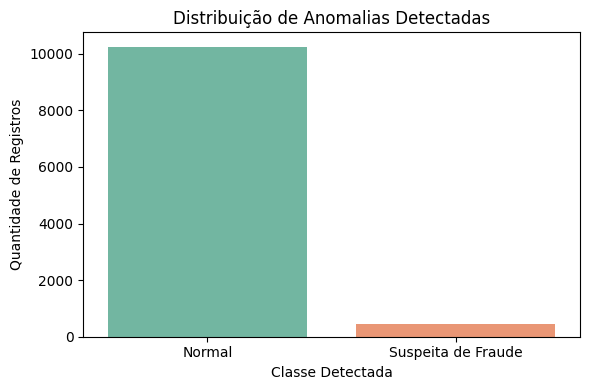

In [52]:
plt.figure(figsize=(6, 4))
sns.countplot(x='suspeita_fraude', hue='suspeita_fraude', data=df, palette='Set2', legend=False)
plt.xticks([0, 1], ['Normal', 'Suspeita de Fraude'])
plt.xlabel("Classe Detectada")
plt.ylabel("Quantidade de Registros")
plt.title("Distribuição de Anomalias Detectadas")
plt.tight_layout()
plt.show()

In [53]:
if 'Sexo' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Sexo', y='Obitos', hue='suspeita_fraude', data=df, palette='coolwarm')
    plt.xlabel("Sexo")
    plt.ylabel("Número de Óbitos")
    plt.title("Distribuição de Óbitos por Sexo e Detecção de Fraudes")
    plt.legend(title="Suspeita de Fraude", labels=["Normal", "Suspeita"])
    plt.tight_layout()
    plt.show()